***
# Project 1 - Phenotypic Prediction from Transcriptomic Features
***



## Imports

In [1]:
import pandas as pd
import numpy as np
import cPickle as pkl
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import utilities
import sys
import os
import gc
import random

## Data Extraction

 Extracted the TPM value for each Accession folder and stored in the 'tpm_train.pkl' file.

In [2]:
with open("tpm_train_with_eqc.pkl", 'rb') as input_file:
    data = pkl.load(input_file)
    

In [3]:
data = pd.DataFrame(data)    
data.set_index(0, inplace=True)

labels = data.iloc[:,-2:]

data.columns = [str(i) for i in data.columns]

In [8]:
X = data.drop(['199327','199328'], axis=1)
y = labels

In [9]:
X = X.astype(np.float32)

In [14]:
X['199326'].describe()

count    369.000000
mean      80.707268
std       17.161161
min       33.948341
25%       69.099884
50%       79.788773
75%       91.965858
max      166.347031
Name: 199326, dtype: float64

In [15]:
X.head()

,1,2,3,4,5,6,7,8,9,10,...,199317,199318,199319,199320,199321,199322,199323,199324,199325,199326
0,,,,,,,,,,,,,,,,,,,,,
ERR188023,0.372590,0.0,4.22841,0.375841,0.000000,0.0,0.000000,0.0,0.038324,0.0,...,90.953598,171.121994,2886.239990,6365.470215,227.203995,4590.790039,353.976990,1974.739990,4.998195,97.296394
ERR188022,0.797727,0.0,4.58229,0.000000,0.000000,0.0,0.000000,0.0,1.684310,0.0,...,22.211201,83.254097,3149.229980,6786.430176,88.995796,3629.209961,437.084015,2652.649902,4.922488,57.534142
ERR188356,0.090220,0.0,8.51668,0.000000,0.000000,0.0,0.000000,0.0,2.274090,0.0,...,25.431000,109.183998,3163.649902,9510.320312,121.857002,5556.990234,586.945007,2406.679932,5.065081,63.784302
ERR188079,0.220742,0.0,3.80056,0.000000,0.000000,0.0,0.000000,0.0,1.131810,0.0,...,229.815994,490.273987,1677.089966,3139.790039,274.553009,1913.510010,529.495972,3157.360107,4.875267,33.948341
ERR188032,0.000000,0.0,4.41379,0.000000,0.001128,0.0,0.936256,0.0,0.686672,0.0,...,71.057800,163.998993,3299.810059,6968.649902,256.239014,3721.270020,521.898010,2534.120117,4.969185,81.912567


In [35]:
y.head()

,199325,199326
0,,
ERR188023,FIN,2
ERR188022,CEU,1
ERR188356,TSI,1
ERR188079,TSI,4
ERR188032,CEU,7


***
## Trying ExtraTreesClassifier on TPM for finding Feature importance

In [16]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, n_jobs=-1, bootstrap=True, oob_score=True, verbose=1,
                              random_state=0)

# using out-of-bag samples for testing generalization accuracy

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1])[:15]:
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.7s finished


Feature ranking:
1. feature 93295 (0.000949)
2. feature 70175 (0.000827)
3. feature 29548 (0.000823)
4. feature 163898 (0.000789)
5. feature 5027 (0.000733)
6. feature 127135 (0.000701)
7. feature 168825 (0.000663)
8. feature 161877 (0.000646)
9. feature 157375 (0.000638)
10. feature 34275 (0.000609)
11. feature 168948 (0.000596)
12. feature 160135 (0.000593)
13. feature 120673 (0.000586)
14. feature 76393 (0.000573)
15. feature 175825 (0.000572)


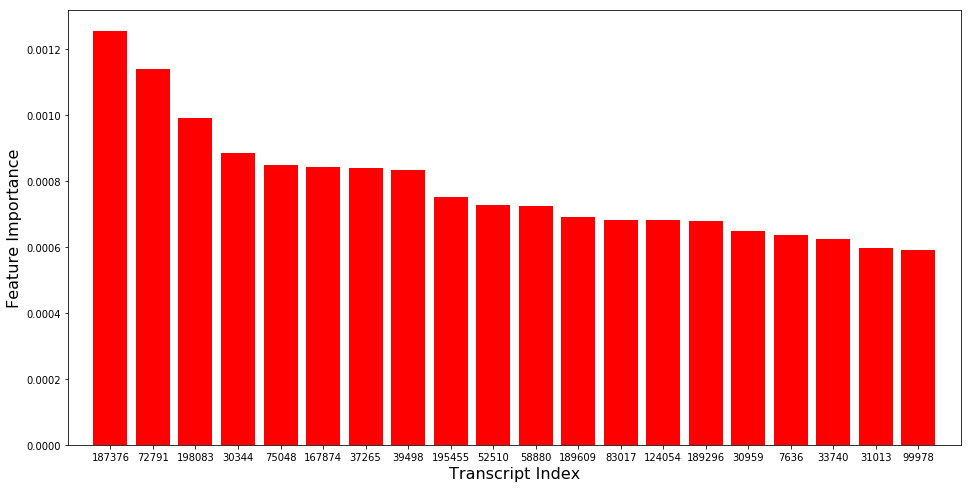

In [26]:
# Plot the feature importances of the forest
count = 20
plt.figure(figsize=(16, 8))
# plt.bar(range(X_train.shape[1]), importances[indices],
#        color="r", yerr=std[indices], align="center")
plt.bar(range(count), importances[indices[:count]],
       color="r", align="center")

# plt.xticks(range(X_train.shape[1]), indices)
plt.xticks(range(count), indices[:count])
plt.xlim([-1, count])
plt.xlabel("Transcript Index", fontsize=16)
plt.ylabel("Feature Importance", fontsize=16)
# plt.xlim([-1, X_train.shape[1]])
plt.show()

### Dumping the variables to pickle
To save processing time for future runs

In [2]:
len(indices)

NameError: name 'indices' is not defined

In [37]:
if not os.path.exists("indices.pkl"):
    with open("indices.pkl", 'wb') as out:
        pkl.dump(indices, out)

In [38]:
if not os.path.exists("X.pkl"):
    with open("X.pkl", 'wb') as out:
        pkl.dump(X, out)

In [39]:
if not os.path.exists("y.pkl"):
    with open("y.pkl", 'wb') as out:
        pkl.dump(y, out)

In [40]:
X = X.iloc[:, indices[:10000]]

In [41]:
if not os.path.exists("X_train_reduced.pkl"):
    with open("X_train_reduced.pkl", 'wb') as out:
        pkl.dump(X, out)

***
## Implementing PCA on the selected important features

In [34]:
pca = PCA(n_components=512)
X_new = pca.fit_transform(X)

In [35]:
X_new.shape

(369, 369)

Interesting observation, after trying PCA we get a worse answer. This is because the fact that we have very less data to train on.<br>
***

## Cross Validation on RandomForestClassifier
<br>
<b>Parameters for the Forest :</b>
- Number of trees = 200
- Max depth of a tree - 60

<b>Parameters Cross validation :</b>
- number of folds = 5

In [114]:
def avg_f1_score(y_test,y_pred):
    pop_score = f1_score(y_test[199325], y_pred[:,0], average='macro',)
    center_score = f1_score(y_test[199326], y_pred[:,1], average='macro')
    return (pop_score+center_score)/2.0
score = make_scorer(avg_f1_score, greater_is_better=True)

In [121]:
le = LabelEncoder()
le.fit(y[199325])
y_enc = y 
y_enc[199325] = le.transform(y[199325])
y_enc[199326] = y_enc[199326].astype('int') 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


***
## After Mid-term

Using information from equivalence classes

# Random Forest New

In [155]:
# random.seed(18)
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
rf_params = {
    'n_estimators':[10,30,50,100,200,250],
    'criterion': ('gini','entropy'),
    'max_depth': [15,20,30,40,60],
    'class_weight' : (None,'balanced','balanced_subsample')
}
gcv_rf = GridSearchCV(cv=4,estimator=rf,param_grid=rf_params,n_jobs=-1,scoring=score,verbose=1)
gcv_rf.fit(X,y_enc)
# scores = cross_val_score(clf, X, y, cv=5, scoring=score)

print gcv_rf.best_estimator_

Fitting 4 folds for each of 180 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.6min
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  6.6min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)


### Best RFC
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
            
cv=4 <br>
0.811905104099 0.0176607853188

In [158]:
print gcv_rf.best_score_

0.811829641971


In [157]:
scores = cross_val_score(gcv_rf.best_estimator_,X,y_enc, cv=4,n_jobs=-1,scoring=score,verbose=1)

print scores.mean(),scores.std()

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.2s finished


0.811905104099 0.0176607853188


# Extra Trees Classifier

In [159]:
etc = ExtraTreesClassifier(n_jobs=-1)
etc_params = {
    'n_estimators':[10,30,50,100,200,250],
    'criterion': ('gini','entropy'),
    'max_depth': [15,20,30,40,60],
    'class_weight' : (None,'balanced','balanced_subsample'),
    
}
gcv_etc = GridSearchCV(cv=4,estimator=etc,param_grid=rf_params,n_jobs=-1,scoring=score,verbose=1)
gcv_etc.fit(X,y_enc)
# scores = cross_val_score(clf, X, y, cv=5, scoring=score)

print gcv_etc.best_estimator_

Fitting 4 folds for each of 180 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.0s
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=60, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [160]:
print gcv_etc.best_score_
scores = cross_val_score(gcv_etc.best_estimator_,X,y_enc, cv=4,n_jobs=-1,scoring=score,verbose=1)

print scores.mean(),scores.std()

0.775486198935


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.1s finished


0.777778749865 0.0137470677549


## KNN Classifiers

In [166]:
knn = KNN(n_jobs=-1)
knn_params = {
    'n_neighbors': [5,10,25,50,100],
    'weights': ['uniform','distance'],
    'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
    'p':[1,2]
}
gcv_knn = GridSearchCV(cv=4,estimator=knn,param_grid=knn_params,n_jobs=-1,scoring=score,verbose=1)
gcv_knn.fit(X,y_enc)
# scores = cross_val_score(clf, X, y, cv=5, scoring=score)

print gcv_knn.best_estimator_

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.0s
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=1,
           weights='distance')


In [167]:
print gcv_knn.best_score_
scores = cross_val_score(gcv_knn.best_estimator_,X,y_enc, cv=4,n_jobs=-1,scoring=score,verbose=1)

print scores.mean(),scores.std()

0.669801705702


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.0s finished


0.66977957859 0.0151012433588


In [112]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)  

scaler = StandardScaler()

scores = []
count =1
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_enc.iloc[train_index], y_enc.iloc[test_index]

    X_train = scaler.fit_transform(X_train)

    clf = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=0, n_jobs=-1,class_weight="balanced_subsample")
    clf.fit(X_train,y_train)
    
    X_test = scaler.transform(X_test)
    y_pred = clf.predict(X_test)
#     print y_pred[:,1]
    pop_score = f1_score(y_test[199325], y_pred[:,0], average='macro')
    center_score = f1_score(y_test[199326], y_pred[:,1], average='macro')
    scores.append((pop_score+center_score)/2.0)
    print str(count) +") f1_score : ", scores[-1]
    count+=1

KFold(n_splits=5, random_state=None, shuffle=False)
1) f1_score :  0.795271667071
2) f1_score :  0.851374047154
3) f1_score :  0.797495437569
4) f1_score :  0.774835746723
5) f1_score :  0.836501830552


In [113]:
print "The average f-1 score is ",sum(scores)/len(scores)

The average f-1 score is  0.811095745814


## MLPClassifier

In [37]:
with open("indices.pkl", 'rb') as in_file:
    indices = pkl.load(in_file)

In [39]:
with open("X_train_reduced.pkl", 'rb') as in_file:
    X = pkl.load(in_file)

In [40]:
with open("y.pkl", 'rb') as in_file:
    y = pkl.load(in_file)

In [63]:
## Performing 5 fold cross validation on MLP Classifier
kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)  

scaler = StandardScaler()

scores = []
count =1
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train = scaler.fit_transform(X_train)

    clf = MLPClassifier(hidden_layer_sizes=(256, 128), activation='logistic', #solver='lbfgs', #learning_rate='adaptive',
                    verbose=False, tol=1e-5 ,max_iter=500, learning_rate_init=0.005
#                     warm_start = True
                   )
    
    clf.fit(X_train, y_train)
    
    X_test = scaler.transform(X_test)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='macro'))
    print count,") f1_score : ", scores[-1]
    count+=1

In [62]:
print "The average f-1 score is ",sum(scores)/len(scores)

The average f-1 score is  0.860651706532


***
## Data Flow pipeline

Changing the approach
    - Making a universal set of all distinct equivalence
    - Given a population, we make a bit vector for all the equi_classes in that population
    - Reducing the number of dimension
    - Using that as a features to our last know best Classifier [MLP]
    

In [65]:
folder_names = utilities.get_folder_names("./train/")

master_set = set()
all_eq_c = {}
count = 0
for f in folder_names:
    with open("./train/" + f +"/bias/aux_info/eq_classes.txt") as eq_file:
        eq_c = eq_file.read()

    eq_c = eq_c.strip()
    eq_c = eq_c.split("\n")
    eq_c = eq_c[199326:]
    
    eq_c = np.array(eq_c)

    cur_eq_c = {}
    
    try:
        for i in range(len(eq_c)):
            e = eq_c[i].split('\t')
            key = int(''.join(e[:-1]))
            cur_eq_c[key] = int(e[-1])
            master_set.add(key)
    except Exception as err:
        print err
        print f,i
    
    all_eq_c[f] = cur_eq_c
    count+=1
    print count
    gc.collect()
    


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


KeyboardInterrupt: 

### Saving the new made sets

In [6]:
pkl.dump(master_set,open('master_set.pkl','wb'))

In [7]:
with open('all_eq_classes.pkl','wb') as f:
    pkl.dump(all_eq_c,f)

In [9]:
tot_size = sys.getsizeof(all_eq_c.values())
tot_size+= sum(map(sys.getsizeof,all_eq_c.itervalues()))
print tot_size/(1024*1024)

0


In [2]:
with open('./master_set.pkl', 'rb') as f:
    master_set = pkl.load(f)
    

In [ ]:
with open('./all_eq_classes.pkl', 'rb') as f:
    all_eq_c = pkl.load(f)

In [8]:
for k in all_eq_c.keys():
    with open('./all_equi_classes/'+k+'.pkl', 'wb') as out_file:
        pkl.dump(all_eq_c[k], out_file)
        del all_eq_c[k]

In [1]:
folder_names = utilities.get_folder_names("./train/")
master_set = list(master_set)

for count, folder in enumerate(folder_names):
#     with open('./eq_classes/'+folder+'.pkl') as acc_file:
#         acc = pkl.load(acc_file)
    acc = all_eq_c[folder]
    
    for i in range(len(master_set)):
        cur = master_set[i]
        if cur in acc:
            acc[i] = acc[cur]
            del acc[cur]
    
    with open('./eq_classes/'+folder+'.pkl', 'wb') as out_file:
        pkl.dump(acc, out_file)
    
    gc.collect()
    print count, "folders done"

In [3]:
folder_names = utilities.get_folder_names("./train/")
train = pd.DataFrame(np.zeros((len(folder_names),len(master_set))), index=folder_names)


In [4]:
count = 1
for folder in folder_names:
    print count
    count+=1
    with open('./eq_classes/'+folder+'.pkl') as acc_file:
        acc = pkl.load(acc_file)

    classes = pd.Series(acc)
    classes.fillna(0, inplace=True)
    
    train.loc[folder] = classes
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [5]:
train.fillna(0, inplace=True)
# train = train.astype('int32')

In [6]:
train = train.astype('int16')

In [7]:
# del master_set
# del all_eq_c
gc.collect()

428

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 369 entries, ERR188021 to ERR188482
Columns: 1235737 entries, 0 to 1235736
dtypes: float64(1235737)
memory usage: 3.4+ GB


In [8]:
label = pd.read_csv('p1_train_pop_lab.csv', index_col=0)
train = train.merge(label, left_index=True, right_index=True)
# train

## Dimensionality Reduction and K-fold Cross Validation

### Both labels together

In [13]:
X = train.drop(['population', 'sequencing_center'], axis=1)
Y = train[['population', 'sequencing_center']]

In [14]:
## Performing 5 fold cross validation on MLP Classifier
kf = KFold(n_splits=5)
kf.get_n_splits(X)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(Y.as_matrix())
y = pd.DataFrame(y)

In [24]:
print(kf)  

scaler = StandardScaler()

scores = []
count =1

for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    forest = ExtraTreesClassifier(n_estimators=250, n_jobs=-1, bootstrap=True, oob_score=True, verbose=0,
                              random_state=0)

    # using out-of-bag samples for testing generalization accuracy

    forest.fit(X_train, y_train)
    importances = forest.feature_importances_

    indices = np.argsort(importances)[::-1]

    
    X_train = X_train.iloc[:, indices[:25000]]
    X_test = X_test.iloc[:,indices[:25000]]
    X_train = scaler.fit_transform(X_train)

    clf = MLPClassifier(hidden_layer_sizes=(256, 128), activation='logistic', #solver='lbfgs', #learning_rate='adaptive',
                    verbose=False, tol=1e-5 ,max_iter=500, learning_rate_init=0.005
#                     warm_start = True
                   )
    
    clf.fit(X_train, y_train)
    
    X_test = scaler.transform(X_test)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='macro'))
    print count,") f1_score : ", scores[-1]
    count+=1
    
print "The average f-1 score is ",sum(scores)/len(scores)

KFold(n_splits=5, random_state=None, shuffle=False)
1 ) f1_score :  0.854989614836
2 ) f1_score :  0.900908119658
3 ) f1_score :  0.897299836718
4 ) f1_score :  0.886236990759
5 ) f1_score :  0.893448828807
The average f-1 score is  0.886576678156


In [15]:
scaler = StandardScaler()

## using saved values for the important indices
with open('both_indices.pkl') as f:
    indices = pkl.load(f)

indices = indices[:25000]

X = X.iloc[:, indices[:25000]]

X = scaler.fit_transform(X)

clf = MLPClassifier(hidden_layer_sizes=(256, 128), activation='logistic', #solver='lbfgs', #learning_rate='adaptive',
                verbose=True, tol=1e-5 ,max_iter=500, learning_rate_init=0.005
                , warm_start = True
               )

clf.fit(X, y)

Iteration 1, loss = 7.32607382
Iteration 2, loss = 4.97176306
Iteration 3, loss = 4.86750125
Iteration 4, loss = 4.90735650
Iteration 5, loss = 4.78165631
Iteration 6, loss = 4.56367620
Iteration 7, loss = 4.33871958
Iteration 8, loss = 4.15616584
Iteration 9, loss = 4.01506739
Iteration 10, loss = 3.88881694
Iteration 11, loss = 3.76518047
Iteration 12, loss = 3.63370226
Iteration 13, loss = 3.50681745
Iteration 14, loss = 3.38176209
Iteration 15, loss = 3.25393049
Iteration 16, loss = 3.12855726
Iteration 17, loss = 2.99799317
Iteration 18, loss = 2.87192923
Iteration 19, loss = 2.75625107
Iteration 20, loss = 2.63658040
Iteration 21, loss = 2.51791778
Iteration 22, loss = 2.39780676
Iteration 23, loss = 2.27591009
Iteration 24, loss = 2.16038470
Iteration 25, loss = 2.04418623
Iteration 26, loss = 1.92673366
Iteration 27, loss = 1.81208284
Iteration 28, loss = 1.69978137
Iteration 29, loss = 1.59979782
Iteration 30, loss = 1.50093172
Iteration 31, loss = 1.40264416
Iteration 32, los

Iteration 253, loss = 0.02352983
Iteration 254, loss = 0.02339224
Iteration 255, loss = 0.02325609
Iteration 256, loss = 0.02311991
Iteration 257, loss = 0.02298501
Iteration 258, loss = 0.02285148
Iteration 259, loss = 0.02272003
Iteration 260, loss = 0.02258752
Iteration 261, loss = 0.02245638
Iteration 262, loss = 0.02232928
Iteration 263, loss = 0.02220084
Iteration 264, loss = 0.02207480
Iteration 265, loss = 0.02194891
Iteration 266, loss = 0.02182541
Iteration 267, loss = 0.02170386
Iteration 268, loss = 0.02158174
Iteration 269, loss = 0.02146219
Iteration 270, loss = 0.02134520
Iteration 271, loss = 0.02122685
Iteration 272, loss = 0.02110953
Iteration 273, loss = 0.02099402
Iteration 274, loss = 0.02087973
Iteration 275, loss = 0.02076518
Iteration 276, loss = 0.02065390
Iteration 277, loss = 0.02054241
Iteration 278, loss = 0.02043226
Iteration 279, loss = 0.02032515
Iteration 280, loss = 0.02021392
Iteration 281, loss = 0.02010871
Iteration 282, loss = 0.02000240
Iteration 

d:\softwares\python\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(256, 128), learning_rate='constant',
       learning_rate_init=0.005, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=1e-05, validation_fraction=0.1,
       verbose=True, warm_start=True)

In [16]:
with open('joint_model.pkl' , 'wb') as f:
    pkl.dump(clf, f)

In [17]:
with open('joint_scalar.pkl' , 'wb') as f:
    pkl.dump(scaler, f)

In [18]:
with open('binarizer.pkl' , 'wb') as f:
    pkl.dump(mlb, f)

**Code to plot the feature importances**

In [64]:
# # Plot the feature importances of the forest
# count = 20
# plt.figure(figsize=(16, 8))
# # plt.bar(range(X_train.shape[1]), importances[indices],
# #        color="r", yerr=std[indices], align="center")
# plt.bar(range(count), importances[indices[:count]],
#        color="r", align="center")

# # plt.xticks(range(X_train.shape[1]), indices)
# plt.xticks(range(count), indices[:count])
# plt.xlim([-1, count])
# plt.xlabel("Transcript Index", fontsize=16)
# plt.ylabel("Feature Importance", fontsize=16)
# # plt.xlim([-1, X_train.shape[1]])
# plt.show()

### For population

In [35]:
X = train.drop(['population', 'sequencing_center'], axis=1)
Y = train['population']

In [2]:
## Performing 5 fold cross validation on MLP Classifier
kf = KFold(n_splits=5)
kf.get_n_splits(X)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(Y.as_matrix())
y = pd.DataFrame(y)


print(kf)  

scaler = StandardScaler()

scores = []
count =1

for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    forest = ExtraTreesClassifier(n_estimators=250, n_jobs=-1, bootstrap=True, oob_score=True, verbose=0,
                              random_state=0)

    # using out-of-bag samples for testing generalization accuracy

    forest.fit(X_train, y_train)
    importances = forest.feature_importances_

    indices = np.argsort(importances)[::-1]

    ## choosing the top 25000 features
    X_train = X_train.iloc[:, indices[:25000]]
    X_test = X_test.iloc[:,indices[:25000]]
    X_train = scaler.fit_transform(X_train)

    clf = MLPClassifier(hidden_layer_sizes=(256, 128), activation='logistic', #solver='lbfgs', #learning_rate='adaptive',
                    verbose=False, tol=1e-5 ,max_iter=500, learning_rate_init=0.005
#                     warm_start = True
                   )
    
    clf.fit(X_train, y_train)
    
    X_test = scaler.transform(X_test)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='macro'))
    print count,") f1_score : ", scores[-1]
    count+=1

print "The average f-1 score is ",sum(scores)/len(scores)


KFold(n_splits=5, random_state=None, shuffle=False)
1 ) f1_score :  0.786531986532
2 ) f1_score :  0.836624869383
3 ) f1_score :  0.866600384019
4 ) f1_score :  0.825254232128
5 ) f1_score :  0.882010582011
The average f-1 score is  0.841059551094


In [20]:
scaler = StandardScaler()

with open('population_indices.pkl') as f:
    indices = pkl.load(f)

indices = indices[:25000]

X = X.iloc[:, indices[:25000]]

X = scaler.fit_transform(X)

clf = MLPClassifier(hidden_layer_sizes=(256, 128), activation='logistic', #solver='lbfgs', #learning_rate='adaptive',
                verbose=True, tol=1e-5 ,max_iter=500, learning_rate_init=0.005
                , warm_start = True
               )

clf.fit(X, Y)

Iteration 1, loss = 1.57276791
Iteration 2, loss = 1.11868326
Iteration 3, loss = 0.81814753
Iteration 4, loss = 0.54588110
Iteration 5, loss = 0.35266619
Iteration 6, loss = 0.23491131
Iteration 7, loss = 0.16289884
Iteration 8, loss = 0.11394666
Iteration 9, loss = 0.08094536
Iteration 10, loss = 0.05926931
Iteration 11, loss = 0.04622317
Iteration 12, loss = 0.03605649
Iteration 13, loss = 0.02944875
Iteration 14, loss = 0.02430509
Iteration 15, loss = 0.02067348
Iteration 16, loss = 0.01748911
Iteration 17, loss = 0.01510565
Iteration 18, loss = 0.01314781
Iteration 19, loss = 0.01190376
Iteration 20, loss = 0.01082991
Iteration 21, loss = 0.00968727
Iteration 22, loss = 0.00888307
Iteration 23, loss = 0.00821061
Iteration 24, loss = 0.00770194
Iteration 25, loss = 0.00729404
Iteration 26, loss = 0.00691950
Iteration 27, loss = 0.00656085
Iteration 28, loss = 0.00632599
Iteration 29, loss = 0.00607057
Iteration 30, loss = 0.00588983
Iteration 31, loss = 0.00565977
Iteration 32, los

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(256, 128), learning_rate='constant',
       learning_rate_init=0.005, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=1e-05, validation_fraction=0.1,
       verbose=True, warm_start=True)

In [21]:
with open('population_model.pkl' , 'wb') as f:
    pkl.dump(clf, f)

In [22]:
with open('population_scalar.pkl' , 'wb') as f:
    pkl.dump(scaler, f)

### For sequencing center

In [23]:
X = train.drop(['population', 'sequencing_center'], axis=1)
y = train['sequencing_center']
# with open('X_reduced.pkl') as f:
    

In [30]:
## Performing 5 fold cross validation on MLP Classifier
kf = KFold(n_splits=5)
kf.get_n_splits(X)

# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(Y.as_matrix())
# y = pd.DataFrame(y)


print(kf)  

scaler = StandardScaler()

scores = []
count = 1

for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    forest = ExtraTreesClassifier(n_estimators=250, bootstrap=True, oob_score=True, verbose=0,
                              random_state=0)

    # using out-of-bag samples for testing generalization accuracy

    forest.fit(X_train, y_train)
    importances = forest.feature_importances_

    indices = np.argsort(importances)[::-1]

    ## choosing the top 25000 features
    X_train = X_train.iloc[:, indices[:25000]]
    X_test = X_test.iloc[:,indices[:25000]]
    X_train = scaler.fit_transform(X_train)

    clf = MLPClassifier(hidden_layer_sizes=(256, 128), activation='logistic', #solver='lbfgs', #learning_rate='adaptive',
                    verbose=False, tol=1e-5 ,max_iter=500, learning_rate_init=0.005
#                     warm_start = True
                   )
    
    clf.fit(X_train, y_train)
    
    X_test = scaler.transform(X_test)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='macro'))
    print count,") f1_score : ", scores[-1]
    count+=1

print "The average f-1 score is ",sum(scores)/len(scores)

KFold(n_splits=5, random_state=None, shuffle=False)
1 ) f1_score :  0.929378894415
2 ) f1_score :  0.979487179487
3 ) f1_score :  0.963213044131
4 ) f1_score :  0.94509695345
5 ) f1_score :  0.856975523656
The average f-1 score is  0.934830319028


We can definitely improve the f1 score and accuracy.
However, the only limitation is of memory.
Since, fitting the entire data structure and other variables in RAM 
along with the overhead of hashing was giving memory errors.
If we can try to run this on a more powerful machine, it will work.

In [24]:
scaler = StandardScaler()

with open('sequencing_indices.pkl') as f:
    indices = pkl.load(f)

indices = indices[:25000]

X = X.iloc[:, indices[:25000]]

X = scaler.fit_transform(X)

clf = MLPClassifier(hidden_layer_sizes=(256, 128), activation='logistic', #solver='lbfgs', #learning_rate='adaptive',
                verbose=True, tol=1e-5 ,max_iter=500, learning_rate_init=0.005
                , warm_start = True
               )

clf.fit(X, Y)

Iteration 1, loss = 1.65318814
Iteration 2, loss = 1.19564005
Iteration 3, loss = 0.94305667
Iteration 4, loss = 0.65540591
Iteration 5, loss = 0.43617899
Iteration 6, loss = 0.29153293
Iteration 7, loss = 0.19698835
Iteration 8, loss = 0.12867314
Iteration 9, loss = 0.08658251
Iteration 10, loss = 0.06162288
Iteration 11, loss = 0.04556163
Iteration 12, loss = 0.03466866
Iteration 13, loss = 0.02696199
Iteration 14, loss = 0.02166828
Iteration 15, loss = 0.01791738
Iteration 16, loss = 0.01515805
Iteration 17, loss = 0.01317262
Iteration 18, loss = 0.01162646
Iteration 19, loss = 0.01049547
Iteration 20, loss = 0.00958515
Iteration 21, loss = 0.00885517
Iteration 22, loss = 0.00827302
Iteration 23, loss = 0.00779755
Iteration 24, loss = 0.00739491
Iteration 25, loss = 0.00705726
Iteration 26, loss = 0.00677506
Iteration 27, loss = 0.00653072
Iteration 28, loss = 0.00631015
Iteration 29, loss = 0.00611592
Iteration 30, loss = 0.00594333
Iteration 31, loss = 0.00578907
Iteration 32, los

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(256, 128), learning_rate='constant',
       learning_rate_init=0.005, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=1e-05, validation_fraction=0.1,
       verbose=True, warm_start=True)

In [25]:
with open('sequencing_model.pkl' , 'wb') as f:
    pkl.dump(clf, f)

In [27]:
with open('sequencing_scalar.pkl' , 'wb') as f:
    pkl.dump(scaler, f)

## Converting feature indices to feature names 

In [28]:
with open('both_indices.pkl') as f:
    indices = pkl.load(f)

indices = indices[:25000]

ma = list(master_set)
multi_features = []
for i in indices:
    multi_features.append(ma[i])
    
with open('multi_features.pkl','wb') as f:
    pkl.dump(multi_features,f)
    


with open('population_indices.pkl') as f:
    pop_indices = pkl.load(f)   
    pop_indices  = pop_indices[:25000]

pop_features = []
for i in pop_indices:
    pop_features.append(ma[i])
    
with open('pop_features.pkl','wb') as f:
    pkl.dump(pop_features,f)
    
    
    
with open('sequencing_indices.pkl') as f:
    seq_indices = pkl.load(f)   
    seq_indices  = seq_indices[:25000]

seq_features = []
for i in seq_indices:
    seq_features.append(ma[i])
    
with open('seq_features.pkl','wb') as f:
    pkl.dump(seq_features,f)

In [29]:
all_scalers = {}
with open('joint_scalar.pkl') as f:
    multi = pkl.load(f)

all_scalers['multi_scaler'] = multi
 

with open('population_scalar.pkl') as f:
    pop = pkl.load(f)   

all_scalers['pop_scaler'] = pop
    
with open('sequencing_scalar.pkl') as f:
    seq = pkl.load(f)   

all_scalers['seq_scaler'] = seq
with open('all_scalers.pkl','wb') as f:
    pkl.dump(all_scalers,f)

In [13]:
len(all_scalers)

3

In [30]:
models = {}
with open('joint_model.pkl') as f:
    multi = pkl.load(f)

models['joint_model'] = multi
 

with open('population_model.pkl') as f:
    pop = pkl.load(f)   

models['population'] = pop
    
with open('sequencing_model.pkl') as f:
    seq = pkl.load(f)   

models['sequencing_center'] = seq
with open('models.pkl','wb') as f:
    pkl.dump(models,f)